# Generating Data with autocorrelation and temporal lag

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Make sine

The data is based on a sine wave with arbitrary parameters

In [5]:
# parameters
f = 0.25
tp = 100
t = np.arange(-10, 10, 1/tp)
s = 1*np.sin(2 * np.pi * f * t + 0)

### Plot

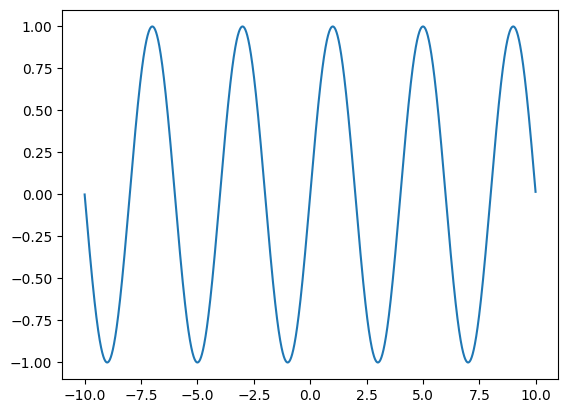

In [6]:
plt.plot(t, s)

## Create data

The data is a voxel X time point matrix, $X$.

### Make empty matrix

In [7]:
X = np.zeros((10, np.size(s)))

### Append generated sine wave

In [9]:
for i in range(len(X)):
    X[i, :] = s

### Plot

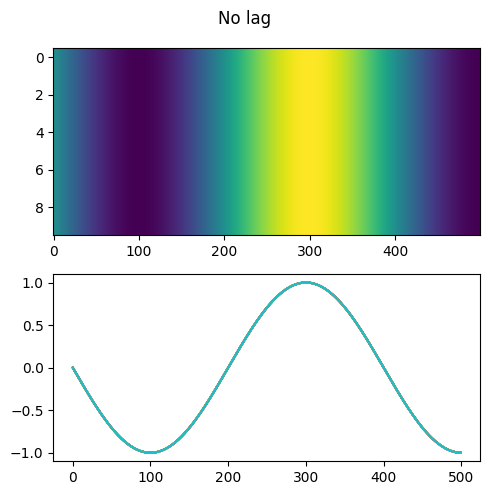

In [49]:
fig , ax = plt.subplots(ncols=1, nrows=2, figsize=(5, 5))
ax[0].imshow(X[0:10, 0:500], aspect='auto');
ax[1].plot(X[0:10, 0:500].T);
fig.suptitle("No lag")
fig.tight_layout()

## Add lag

Here, the lag is denoted as a phase shift, $\theta$, which has been arbitrarily chosen as $0.2$ $\text{radians}$. 

### Phase shift

In [58]:
theta = np.arcsin(0.2)

### Update data

Create new "lagged" data

In [66]:
X_1 = X
X_1[0, :] = 2 * np.pi * f * t + 0
for i in range(1, len(X_1)):
    X_1[i, :] = 1*np.sin(X_1[0, :] + theta + i)

X_1[0, :] = 1*np.sin(2 * np.pi * f * t + 0)

### Plot

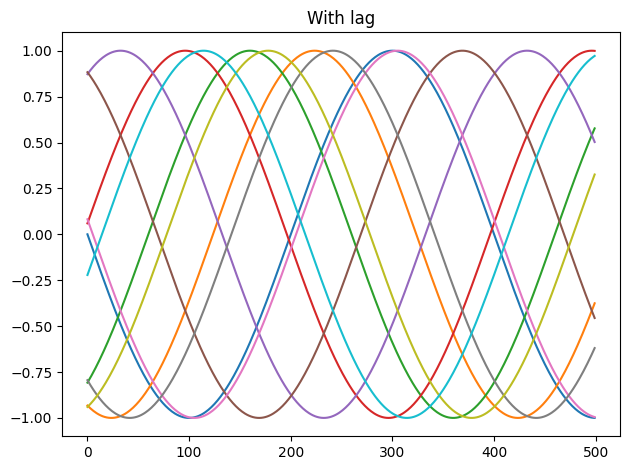

In [69]:
plt.plot(X_1[0:10, 0:500].T);
plt.title("With lag")
plt.tight_layout()